<a id="introduction"></a>
## Introduction to Dimensionality Reduction
#### By Paul Hendricks
-------

In this notebook, we will show how to do GPU accelerated Dimensionality Reduction in RAPIDS.

**Table of Contents**

* [Introduction to Dimensionality Reduction](#introduction)
* [Principle Components Analysis](#pca)
* [Truncated SVC](#tvsd)
* [UMAP](#umap)
* [Setup](#setup)
* [Conclusion](#conclusion)

Before going any further, let's make sure we have access to `matplotlib`, a popular Python library for visualizing data.

In [1]:
import os

try:
    import matplotlib
except ModuleNotFoundError:
    os.system('conda install -y matplotlib')

<a id="setup"></a>
## Setup

This notebook was tested using the following Docker containers:

* `rapidsai/rapidsai-nightly:0.8-cuda10.0-devel-ubuntu18.04-gcc7-py3.7` from [DockerHub - rapidsai/rapidsai-nightly](https://hub.docker.com/r/rapidsai/rapidsai-nightly)

This notebook was run on the NVIDIA Tesla V100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here: https://github.com/rapidsai/notebooks/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [2]:
!nvidia-smi

Tue Jun 11 01:37:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   39C    P0    44W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   39C    P0    42W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

Next, let's see what CUDA version we have:

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


Next, let's load some helper functions from `matplotlib` and configure the Jupyter Notebook for visualization.

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


%matplotlib inline

<a id="Data"></a>
## Data

We'll start by loading the Digits dataset. This dataset is composed of 1,797 images of hand written digits, each of shape 8 x 8 (64 total columns when flattended) .

In [5]:
import numpy as np; print('NumPy Version:', np.__version__)
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.datasets import load_digits


digits = load_digits()
X, y = digits['data'], digits['target']
X, y = X.astype(np.float32), y.astype(np.float32)
print('X: ', X.shape, X.dtype, 'y: ', y.shape, y.dtype)

NumPy Version: 1.16.2
Scikit-Learn Version: 0.21.2
X:  (1797, 64) float32 y:  (1797,) float32


Let's visualize several examples from our dataset:

<Figure size 432x288 with 0 Axes>

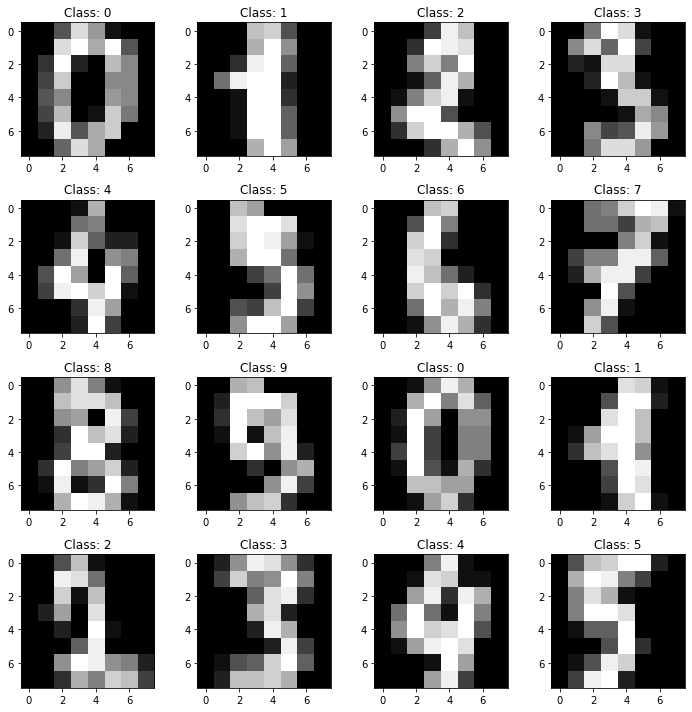

In [6]:
# create figure
figure = plt.figure()
f, axes = plt.subplots(4, 4, figsize=(10, 10))

i = 0
for row in axes:
    for axis in row:
        axis.imshow(X[i].reshape(8, 8), cmap='gray')
        axis.set_title('Class: ' + str(int(y[i])))
        i += 1
    
plt.tight_layout()
plt.show()

<a id="pca"></a>
## Principle Components Analysis

PCA (Principal Component Analysis) is a fundamental dimensionality reduction technique used to combine features in X in linear combinations such that each new component captures the most information or variance of the data. `n_components`is usually small, say at 3, where it can be used for data visualization, data compression and exploratory analysis.

cuML’s `PCA` expects a cuDF DataFrame, and provides 2 algorithms Full and Jacobi. Full (default) uses a full eigendecomposition then selects the top K eigenvectors. The Jacobi algorithm is much faster as it iteratively tries to correct the top K eigenvectors, but might be less accurate.

Before we fit a PCA model to the data, we'll standardize the data using Scikit-Learn's `StandardScaler` class.

In [7]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

We can fit this object to the dataset using the `fit` and `transform` methods.

In [8]:
scaler.fit(X)
X_scaled = scaler.transform(X)

Next, we'll import the `PCA` class from Scikit-Learn and instantiate a model.

In [9]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

We can fit this model to our data and then use that estimated model to reduce our dataset to the 2 principle components that explain as much variation in the data as possible.

In [10]:
pca.fit(X_scaled)
components = pca.transform(X_scaled)
components

array([[ 1.9142123 , -0.9544852 ],
       [ 0.58898085,  0.9246172 ],
       [ 1.3020418 , -0.31719717],
       ...,
       [ 1.022598  , -0.14790916],
       [ 1.0760531 , -0.3809019 ],
       [-1.2577028 , -2.2275772 ]], dtype=float32)

Since we've reduced our dataset to 2 dimensions, we can easily visualize this dataset. The below code will plot each digit with its associated principle component values. Images within a class are visually similar; these images will appear within clusters. Additionally, classes that are visually similar (6s may look like 0s; 3s and 9s may look like 8s; etc.) are going to appear closer to each other. 

With this reduced dimensionality, it's easier to train an algorithm to classify an image into a class. Reducing the dimensionality of a dataset before building a classification or regression model is a common step in machine learning.

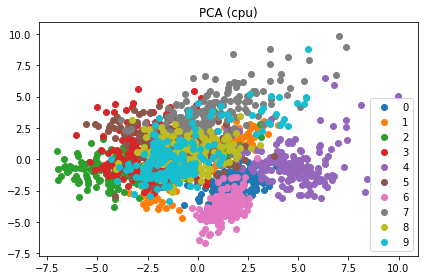

In [11]:
# set colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']
colors = ['tab:' + color for color in colors]

# create figure
figure = plt.figure()
axis = figure.add_subplot(111)

for i in range(10):
    mask = y == i
    axis.scatter(components[mask, 0], components[mask, 1], 
                 c=colors[i], label=str(i))
axis.set_title('PCA (cpu)')

plt.legend()
plt.tight_layout()
plt.show()

The previous example used the Scikit-Learn implementation of PCA which is CPU-based. We can use a GPU accelerated version of this algorithm using the cuML library in RAPIDS.

First, let's convert our data from a NumPy array representation to a Pandas DataFrame.

In [12]:
import pandas as pd; print('Pandas Version:', pd.__version__)


X_scaled_df = pd.DataFrame(X_scaled)
X_scaled_df.columns = ['feature_' + str(i) for i in range(X_scaled_df.shape[1])]

Pandas Version: 0.23.4


Next, we'll convert our Pandas DataFrame to a cuDF DataFrame.

In [13]:
import cudf; print('cuDF Version:', cudf.__version__)


X_scaled_cudf = cudf.DataFrame.from_pandas(X_scaled_df)

cuDF Version: 0.7.2+0.g3ebd286.dirty


Similar to Scikit-Learn, we can import a PCA model from cuML and instantiate it.

In [14]:
import cuml; print('cuML Version:', cuml.__version__)
from cuml.decomposition import PCA as PCA_GPU


pca_gpu = PCA_GPU(n_components=2)

cuML Version: 0.8.0a+1003.g7f9e070c


We can fit our PCA model to the data using the `fit` method and transform the dataset into principle components using the `transform` method.

In [15]:
pca_gpu.fit(X_scaled_cudf)
components_gpu = pca_gpu.transform(X_scaled_cudf).to_pandas().values
components_gpu

array([[ 1.9142134, -0.9544999],
       [ 0.5889807,  0.924634 ],
       [ 1.3020394, -0.3171908],
       ...,
       [ 1.0225962, -0.1479119],
       [ 1.0760548, -0.380906 ],
       [-1.2577021, -2.2275913]], dtype=float32)

Let's visualize the PCA components generated by the GPU model and compare them to those generated by the CPU model. They should be exactly the same!

<Figure size 432x288 with 0 Axes>

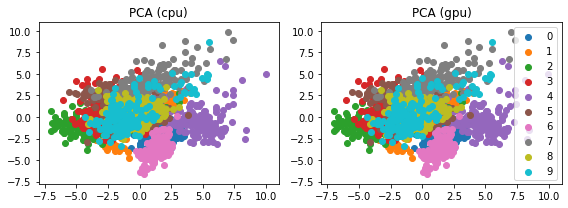

In [16]:
# create figure
figure = plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

for i in range(10):
    mask = y == i
    ax1.scatter(components[mask, 0], components[mask, 1], 
                c=colors[i], label=str(i))
    ax2.scatter(components_gpu[mask, 0], components_gpu[mask, 1], 
                c=colors[i], label=str(i))
ax1.set_title('PCA (cpu)')
ax2.set_title('PCA (gpu)')
    
plt.legend()
plt.tight_layout()
plt.show()

<a id="tvsd"></a>
## Truncated SVD

TruncatedSVD is used to compute the top K singular values and vectors of a large matrix X. It is much faster when `n_components` is small, such as in the use of PCA when 3 components is used for 3D visualization.

cuML’s `TruncatedSVD` expects a cuDF DataFrame, and provides 2 algorithms Full and Jacobi. Full (default) uses a full eigendecomposition then selects the top K singular vectors. The Jacobi algorithm is much faster as it iteratively tries to correct the top K singular vectors, but might be less accurate.

Below, we import the `TruncatedSVD` from Scikit-Learn and instantiate it.

In [17]:
from sklearn.decomposition import TruncatedSVD


tsvd = TruncatedSVD(n_components=2)

Previously, we fitted the model using the `fit` method and used the model to transform the dataset into components using the `transform`. Using the `fit_transform`, we can accomplish both of these steps in one line of code.

In [18]:
components = tsvd.fit_transform(X)
components

array([[45.86133  , -1.1921695],
       [55.529686 ,  7.861933 ],
       [55.827892 ,  6.9146724],
       ...,
       [65.526985 , 10.659046 ],
       [58.606163 , -4.910651 ],
       [64.448235 , -0.4555589]], dtype=float32)

Like before, we can visualize the components.

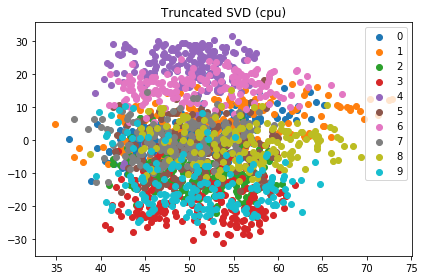

In [19]:
# create figure
figure = plt.figure()
axis = figure.add_subplot(111)

for i in range(10):
    mask = y == i
    axis.scatter(components[mask, 0], components[mask, 1], 
                 c=colors[i], label=str(i))
axis.set_title('Truncated SVD (cpu)')

plt.legend()
plt.tight_layout()
plt.show()

Let's accomplish the same workflow using cuDF and cuML. We'll first prepare our data:

In [20]:
X_df = pd.DataFrame(X)
X_df.columns = ['feature_' + str(i) for i in range(X_df.shape[1])]
X_cudf = cudf.DataFrame.from_pandas(X_df)

Next, we'll instantiate the GPU-accelerated version of `TruncatedSVD` from cuML.

In [21]:
from cuml.decomposition import TruncatedSVD as TruncatedSVD_GPU


tvsd_gpu = TruncatedSVD_GPU(n_components=2)

We'll use the `fit_transform` method to fit the model and transform the data.

In [22]:
components_gpu = tvsd_gpu.fit_transform(X_cudf).to_pandas().values
components_gpu

array([[45.861267  , -1.1921719 ],
       [55.52967   ,  7.8618374 ],
       [55.827877  ,  6.9146295 ],
       ...,
       [65.52698   , 10.65874   ],
       [58.606155  , -4.911291  ],
       [64.44822   , -0.45555496]], dtype=float32)

Lastly, we'll visualize the resulting components and show the CPU-based results and the GPU-based results side-by-side.

<Figure size 432x288 with 0 Axes>

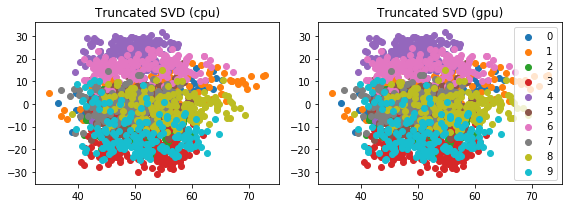

In [23]:
# create figure
figure = plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

for i in range(10):
    mask = y == i
    ax1.scatter(components[mask, 0], components[mask, 1], 
                c=colors[i], label=str(i))
    ax2.scatter(components_gpu[mask, 0], components_gpu[mask, 1], 
                c=colors[i], label=str(i))
ax1.set_title('Truncated SVD (cpu)')
ax2.set_title('Truncated SVD (gpu)')
    
plt.legend()
plt.tight_layout()
plt.show()

<a id="umap"></a>
## UMAP

Uniform Manifold Approximation and Projection Finds a low dimensional embedding of the data that approximates an underlying manifold.

We'll import the `UMAP` class from cuML and instantiate it.

In [24]:
from cuml import UMAP as UMAP_GPU


umap_gpu = UMAP_GPU(n_neighbors=10, n_components=2)

We'll use the `fit_transform` method to fit the model and transform the data.

In [25]:
components_gpu = umap_gpu.fit_transform(X_cudf).to_pandas().values
components_gpu

array([[ 1.6986314 , -9.11737   ],
       [-1.2601967 ,  1.4384024 ],
       [ 0.8524442 ,  3.0218246 ],
       ...,
       [-0.48561373,  0.4266999 ],
       [ 4.034826  , -0.6370797 ],
       [-0.24563256, -0.01475576]], dtype=float32)

Lastly, we'll visualize the resulting components.

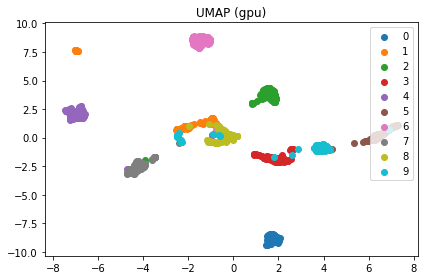

In [26]:
# create figure
figure = plt.figure()
axis = figure.add_subplot(111)

for i in range(10):
    mask = y == i
    axis.scatter(components_gpu[mask, 0], components_gpu[mask, 1], 
                 c=colors[i], label=str(i))
axis.set_title('UMAP (gpu)')

plt.legend()
plt.tight_layout()
plt.show()

<a id="conclusion"></a>
## Conclusion

In this notebook, we showed how to do GPU accelerated Dimensionality Reduction in RAPIDS.

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)
